In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import numpy as np
import pandas as pd
import os
from tqdm import tqdm  
from cpd_model import parse_args, learn_one_seq_penalty
from data_generator import generate_x, generate_gmm_data_segments, softmax

# Segment 1: baseline (centered near origin)
mean_funcs_seg1 = [
    lambda x: np.array([x[0], x[1], x[2]]),
    lambda x: np.array([np.sin(x[0]), np.cos(x[1]), np.tanh(x[2])]),
    lambda x: np.array([x[0]**2, -x[1], 0.5*x[2]])
]
weight_func_seg1 = lambda x: softmax([x[0], -x[1], 0.3*x[2]])

# Segment 2: positive drift + nonlinear
mean_funcs_seg2 = [
    lambda x: np.array([4 + 2*x[0] + x[0]**2, 3*x[1] + 1, 2*x[2] + np.sin(2*x[0])]),
    lambda x: np.array([np.sin(2*x[0]) + 3, np.cos(2*x[1]) + 3, np.tanh(2*x[2])]),
    lambda x: np.array([x[0]**2 + 2, x[1] + 2, 1.5*x[2] + 2])
]
weight_func_seg2 = lambda x: softmax([-2*x[0] + 1, 2*x[1], np.sin(x[2])])

# Segment 3: negative drift + shape inversion
mean_funcs_seg3 = [
    lambda x: np.array([-5 + -3*x[0] + x[0]**2, -2*x[1], -1.5*x[2] + np.cos(3*x[0])]),
    lambda x: np.array([-2*np.sin(x[0]) - 4, -np.cos(x[1]) - 4, -np.tanh(x[2])]),
    lambda x: np.array([-x[0]**2 - 3, -x[1] - 3, -1.2*x[2] - 3])
]
weight_func_seg3 = lambda x: softmax([3*x[0], -2*x[1], np.cos(x[2])])

# Segment 4: strong shift to a new region
mean_funcs_seg4 = [
    lambda x: np.array([10 + 4*x[0] + 2*x[0]**2, 8*x[1] - 4, 6*x[2] + np.sin(4*x[0])]),
    lambda x: np.array([5*np.sin(3*x[0]) + 8, 5*np.cos(3*x[1]) + 8, 3*np.tanh(4*x[2])]),
    lambda x: np.array([6 - 2*x[0], 4*x[1]**2 + 3, 5*np.exp(-x[2]**2)])
]
weight_func_seg4 = lambda x: softmax([-4*x[0] + 3, 3*x[1] - 2, 5*np.sin(x[2])])

# Combine into lists for generator
mean_funcs_list = [mean_funcs_seg1, mean_funcs_seg2, mean_funcs_seg3, mean_funcs_seg4]
weight_funcs_list = [weight_func_seg1, weight_func_seg2, weight_func_seg3, weight_func_seg4]



def run_multiple_experiments(n_repeats=20, save_path="./exp_results.pkl"):
    save_dir = "./reps_sim_dat"
    os.makedirs(save_dir, exist_ok=True)

    args = parse_args()
    """
    parser.add_argument('--z_dim', default=1, type=int) 
    parser.add_argument('--x_dim', default=3, type=int) 
    parser.add_argument('--y_dim', default=3, type=int)
    parser.add_argument('--K_dim', default=3, type=int)
    parser.add_argument('--output_layer', nargs='+', type=int, default=[128,128]) 
    parser.add_argument('--num_samples', default=100, type=int) 
    parser.add_argument('--num_time', default=200, type=int)
    parser.add_argument('--penalties', nargs='+', type=float, default=[0.01,0.1,0.5,1,10,100])
    parser.add_argument('--epoch', default=50, type=int)
    parser.add_argument('--decoder_lr', default=0.01, type=float)
    parser.add_argument('--langevin_K', default=100, type=int)
    parser.add_argument('--langevin_s', default=0.1, type=float)
    parser.add_argument('--kappa', default=0.1, type=float)
    parser.add_argument('--nu_iteration', default=20, type=int)
    parser.add_argument('--decoder_iteration', default=20, type=int)
    parser.add_argument('--loss_thr', default=1e-10, type=float)
    parser.add_argument('--iter_thr', default=5, type=int)
    parser.add_argument('--true_CP_full', nargs='+', type=int, default=[51,101,151])
    parser.add_argument('--signif_level', default=0.975, type=float)
    args, _ = parser.parse_known_args()
    """
    args.epoch = 30
    args.zdim = 3
    args.output_layer = [1000,1000]
    args.kappa = 0.2
    args.decoder_lr = 0.001
    print(f"[INFO] Epochs = {args.epoch}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[INFO] Using device:", device)

    all_results = []

    for rep in tqdm(range(n_repeats), desc="Overall progress", unit="rep"):
        np.random.seed(rep)

        # ===== 1. Generate X and Y via new GMM generator =====
        X = generate_x(T=args.num_time, N=args.num_samples, dx=args.x_dim)
        X, Y, comp_labels = generate_gmm_data_segments(
            X, mean_funcs_list, weight_funcs_list,
            change_points=[51,101,151],  # single change point
            K=3, dy=args.y_dim
        )

        # ===== 2. Save simulated data =====
        x_path = f"{save_dir}/x_rep{rep}.csv"
        y_path = f"{save_dir}/y_rep{rep}.csv"
        label_path = f"./reps_sim_dat/comp_labels_rep{rep}.csv"
        pd.DataFrame(X.reshape(-1, args.x_dim)).to_csv(x_path, index=False)
        pd.DataFrame(Y.reshape(-1, args.y_dim)).to_csv(y_path, index=False)
        pd.DataFrame(comp_labels.reshape(-1, 1), columns=["label"]).to_csv(label_path, index=False)
        print(f"[INFO] rep {rep} saved: {x_path}, {y_path}")

        # ===== 3. Normalize X =====
        X_flat = X.reshape(-1, args.x_dim)
        X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
        X_flat = (X_flat - X_mean) / X_std
        X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

        # ===== 4. Convert to torch tensors =====
        x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
        y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim),
                                dtype=torch.float32).to(device)

        # ===== 5. Split into training/testing =====
        odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
        x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
        y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

        # ===== 6. Grid search over penalties =====
        results_half = []
        for penalty in tqdm(args.penalties, desc=f"rep {rep+1} penalties", leave=False):
            loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test,
                                              penalty=penalty, half=True)
            results_half.append([loss, pen])
        results_half = np.array(results_half)

        best_idx = np.argmin(results_half[:, 0])
        best_penalty = args.penalties[best_idx]
        print(f"[INFO] Best penalty={best_penalty}")

        # ===== 7. Full model with best penalty =====
        res_full = learn_one_seq_penalty(
            args,
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            penalty=best_penalty,
            half=False
            )


        all_results.append({
            "rep": rep,
            "results_half": results_half.tolist(),
            "best_penalty": best_penalty,
            "res_full": res_full
        })

    df_results = pd.DataFrame(all_results)
    df_results.to_pickle(save_path)
    print(f"\n[INFO] Saved all results to {save_path}")
    return df_results


# ==============================================================
# Run experiments
# ==============================================================

if __name__ == "__main__":
    res = run_multiple_experiments(n_repeats=20)


[INFO] Epochs = 30
[INFO] Using device: cuda


Overall progress:   0%|          | 0/20 [00:00<?, ?rep/s]

[INFO] rep 0 saved: ./reps_sim_dat/x_rep0.csv, ./reps_sim_dat/y_rep0.csv


[INFO] Loaded X shape = (200, 100, 3), Y shape = (200, 100, 3)


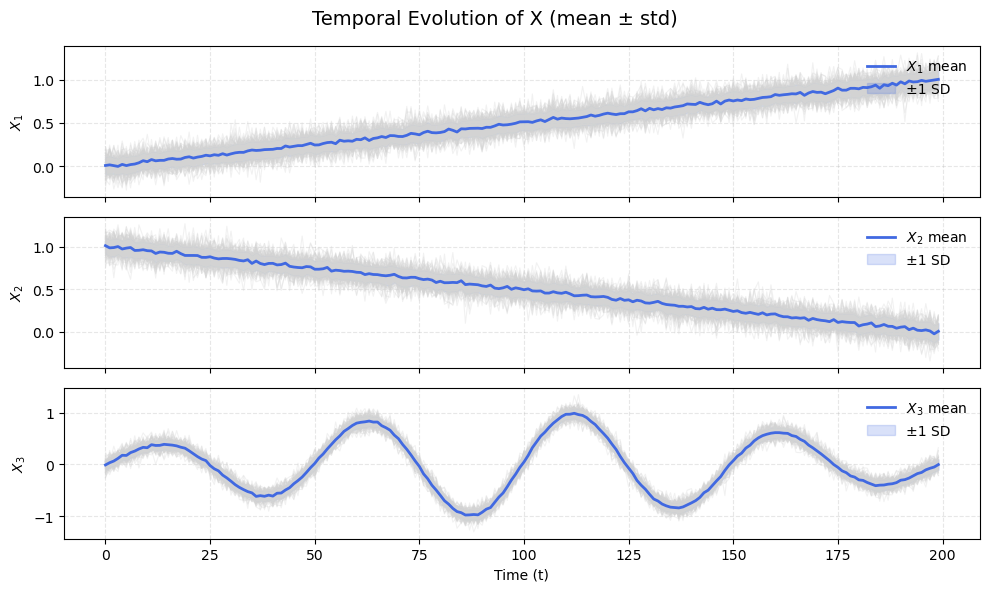

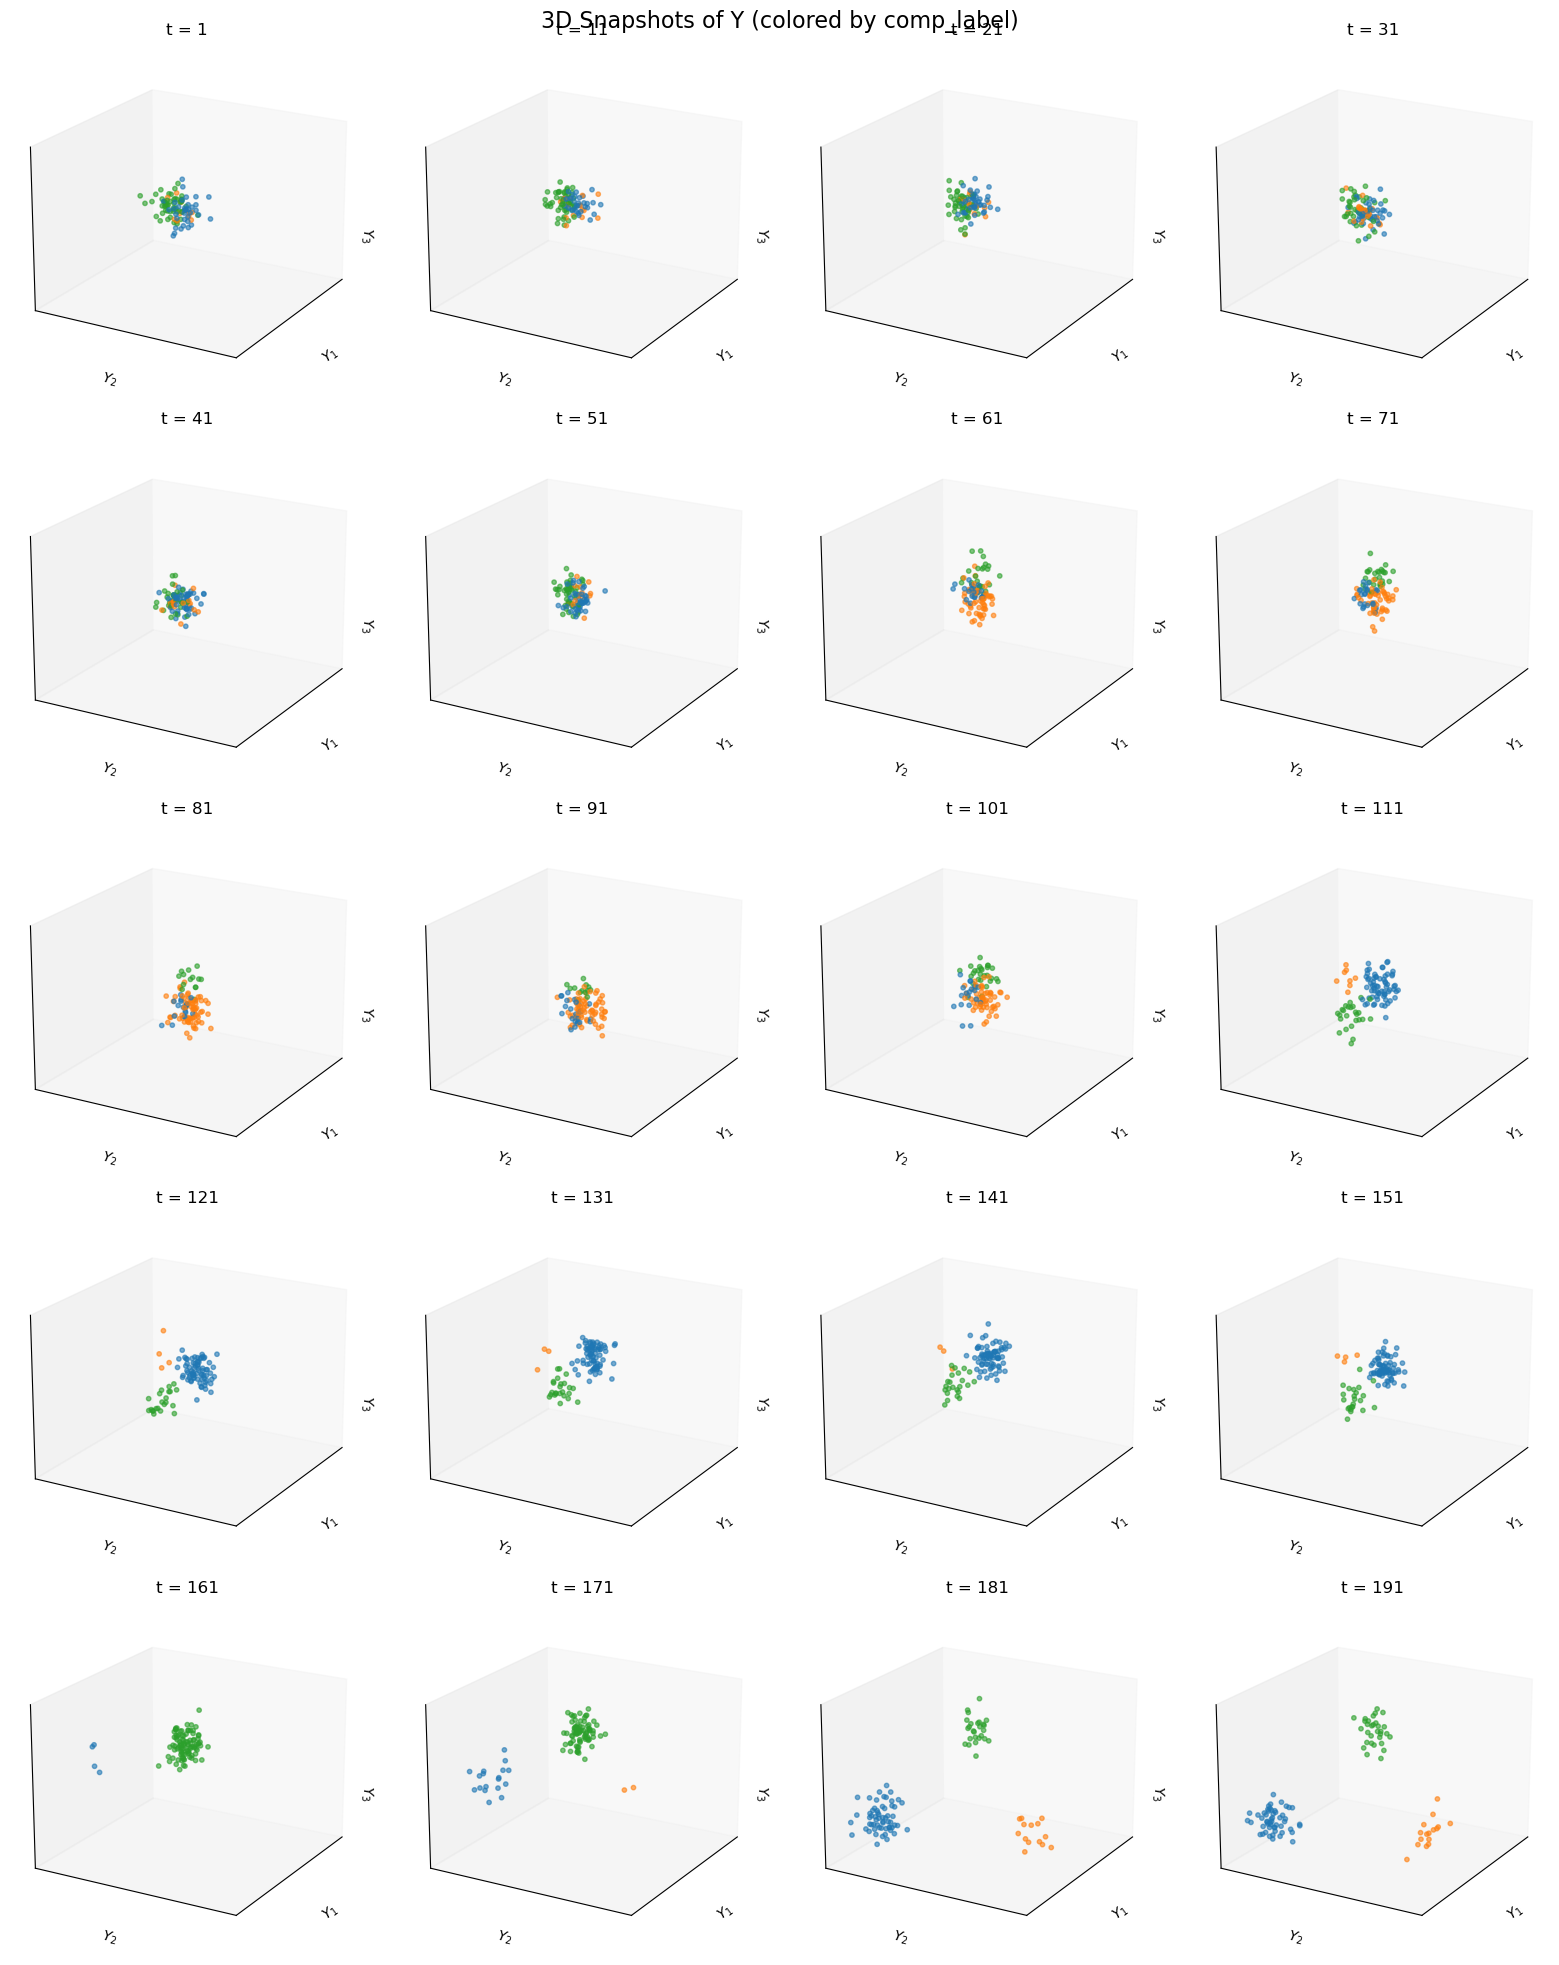

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generator import visualize_X_timeseries, visualize_Y_grid 

rep = 0 
x_path = f"./reps_sim_dat/x_rep{rep}.csv"
y_path = f"./reps_sim_dat/y_rep{rep}.csv"
label_path = f"./reps_sim_dat/comp_labels_rep{rep}.csv"

x_dim = 3
y_dim = 3
num_time = 200
num_samples = 100 

X_flat = pd.read_csv(x_path).to_numpy()
Y_flat = pd.read_csv(y_path).to_numpy()

X = X_flat.reshape(num_time, num_samples, x_dim)
Y = Y_flat.reshape(num_time, num_samples, y_dim)
labels = pd.read_csv(label_path).to_numpy().reshape(num_time, num_samples)
print(f"[INFO] Loaded X shape = {X.shape}, Y shape = {Y.shape}")


visualize_X_timeseries(X)

visualize_Y_grid(Y, step=10, ncols=4, labels=labels)


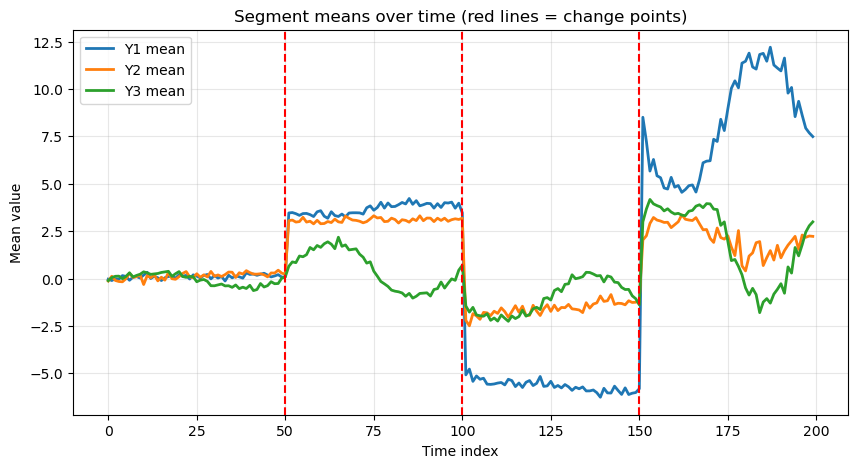

In [3]:
t = np.arange(num_time)
Y_mean = Y.mean(axis=1)  # shape (T, y_dim)

plt.figure(figsize=(10,5))
for d in range(y_dim):
    plt.plot(t, Y_mean[:, d], label=f"Y{d+1} mean", lw=2)

# change points (vertical lines)
for cp in [51, 101, 151]:
    plt.axvline(cp-1, color="red", linestyle="--", lw=1.5)

plt.title("Segment means over time (red lines = change points)")
plt.xlabel("Time index")
plt.ylabel("Mean value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
